# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from sklearn.preprocessing import normalize
from tqdm import trange
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wget

## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip


Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
MOVIELENS_DIR = "ml-100k"

In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)
print("Rating DF shape:", rating_df.shape)

Number of users: 943
Number of items: 1682
Rating DF shape: (100000, 4)


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix=np.zeros((num_users, num_items), dtype=np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [0]:
processedRating_Df=dataPreprocessor(rating_df, num_users, num_items)
print(processedRating_Df.shape)

(943, 1682)


In [0]:
#create training and testing dataset since the class provide the process of raw data and shape them into the same shape, no need to perform that here
fields = ['userID', 'itemID', 'rating', 'timestamp']
trainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.base'), sep='\t', names=fields)
testDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u1.test'), sep='\t', names=fields)

print(trainDF.shape)
print(testDF.shape)

(80000, 4)
(20000, 4)


### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          
            # select the row for user
            # what's the shape of userVector---1682,1
          userVector = train_matrix[user, :]

            # Extract the items the user already rated
          ratedItems = userVector[userVector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
          if ratedItems.size == 0:
            #print(item)
            itemAvg = 0
          else:
            itemAvg = ratedItems.mean()
          predictionMatrix[user, item] = itemAvg
          if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
            itemPopularity[item] = 0#if no one rated the movie then mark it as 0
            
          else:
            
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated#if had been rated calculate the average
        
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          
          predictionMatrix[user, item] = itemPopularity[item]

          # report progress every 100 users
          if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))
             
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples(), position=0, leave=True):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()
print(type(x),type(x),x[195][241])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 0.7606837606837606


In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:32, 1085.59it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
y=average_user_rating_recsys.getModel()
print(y[195][241])

3.6153846153846154


In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:35, 1045.03it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)


In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        
        similarity_matrix=1/(pairwise_distances(matrix, metric = 'euclidean') + 1 )
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        #l2 normalization makes the manhattan and euclidean the same 
        similarity_matrix=1/(pairwise_distances(matrix, metric = 'manhattan') + 1 )
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity=self.method(train_matrix)
            #print(uu_similarity.shape)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model=predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            
            temp_matrix = np.zeros(train_matrix.shape)#943*1682
            temp_matrix[train_matrix.nonzero()] = 1
            trans_train_matrix=np.transpose(train_matrix)#1682*943
            #print(trans_train_matrix.shape)
            ii_similarity=self.method(trans_train_matrix)#1682*1682
            #print(ii_similarity.shape)
            normalizer = np.matmul(ii_similarity,temp_matrix.T)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(ii_similarity,trans_train_matrix)/normalizer
            useraverage = np.sum(trans_train_matrix, axis=1)/np.sum(temp_matrix.T, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            print(predictionMatrix.shape)
            self.__model=predictionMatrix.T

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples(), position=0, leave=True):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)

SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

The cosine should work better, because the magnitude of the vectors does not matter and their similarity can be better examined by the vector angle instead of distance. In this case, for cosine metric only the vectors on the diagonal are 1 and the rest are all zero, which perfectly matches our expectation.

In [0]:
simObject=SimBasedRecSys('item','cosine')
simObject.predict_all(rating_df, num_users, num_items)

(1682, 943)


### (b)

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Manhattan distance measures the distance between two points measured along axes at right angles, thus its value can tell the distance between vectors which can be used to measure vector similarity.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:30, 1101.50it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
item_cosine_recsys=SimBasedRecSys('item','cosine')
algorithms=[user_cosine_recsys,item_cosine_recsys]


In [0]:
cv_rmse = CrossValidation('RMSE')
cv_rmse.run(algorithms, num_users, num_items)

Processing algorithm user-cosine


20000it [00:09, 2118.28it/s]
20000it [00:09, 2135.57it/s]
20000it [00:09, 2132.70it/s]
20000it [00:09, 2071.04it/s]
20000it [00:09, 2105.06it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
163it [00:00, 1624.68it/s]

(1682, 943)


20000it [00:09, 2130.13it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
164it [00:00, 1637.25it/s]

(1682, 943)


20000it [00:09, 2102.14it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
163it [00:00, 1622.20it/s]

(1682, 943)


20000it [00:09, 2105.38it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
158it [00:00, 1574.12it/s]

(1682, 943)


20000it [00:09, 2108.30it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
162it [00:00, 1617.80it/s]

(1682, 943)


20000it [00:09, 2095.35it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

Item-Cosine:mean-1.020082900106248 confidence interval:1.0068242686250732,1.0333415315874226

User-Cosine:mean-1.0173541216605808 confidence interval:1.009013080226148,1.0256951630950135

I think user based recommendation may be able to perform better, because the number of user rating is far smaller than the number of item rating, and the sparisity of user rating makes it hard to find similar users for recommendation.

In [0]:
algorithm_instances = [popularity_recsys, average_user_rating_recsys,user_cosine_recsys]
cv_patk = CrossValidation('P@K')
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2085.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2124.17it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2120.67it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2158.88it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2133.58it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2127.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2126.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2141.48it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2160.06it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2112.38it/s]


Processing algorithm user-cosine


20000it [00:09, 2038.50it/s]
20000it [00:09, 2129.52it/s]
20000it [00:09, 2124.53it/s]
20000it [00:09, 2146.54it/s]
20000it [00:09, 2114.69it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1 * np.random.randn(num_item,self.num_feat)  # item M x D 
        self.w_User = 0.1 * np.random.randn(num_user,self.num_feat)   # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')
                #print(batch_UserID.shape,self.mean_rating_train)
                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],self.w_Item[batch_ItemID, :]),axis=1)  
                #print(pred_out.shape)
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[np.array(val_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(val_vec[:, 1], dtype='int32'), :]),
                                      axis=1)
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      #print(pmf.rmse_train)
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

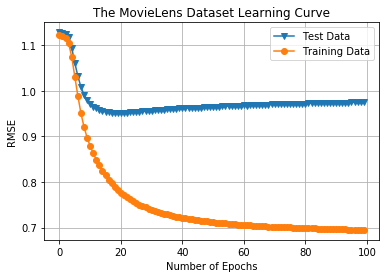

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

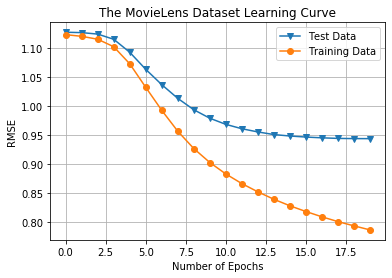

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

From the graph we can see that when max epoch=20 the test error is flat and that is our optimal choice for epoch number.

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

## Q5

### (a)

In [0]:
algorithm_instances = [popularity_recsys, average_user_rating_recsys,user_cosine_recsys,item_cosine_recsys,pmf]
cv_patk = CrossValidation('P@K')
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2119.28it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2109.45it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2112.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2128.66it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2126.98it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2095.27it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2137.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2093.41it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2109.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2100.27it/s]


Processing algorithm user-cosine


20000it [00:09, 2059.31it/s]
20000it [00:09, 2107.91it/s]
20000it [00:09, 2124.71it/s]
20000it [00:09, 2128.40it/s]
20000it [00:09, 2134.53it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
148it [00:00, 1478.77it/s]

(1682, 943)


20000it [00:09, 2132.99it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
159it [00:00, 1588.34it/s]

(1682, 943)


20000it [00:09, 2124.70it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
162it [00:00, 1614.71it/s]

(1682, 943)


20000it [00:09, 2105.32it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
160it [00:00, 1595.10it/s]

(1682, 943)


20000it [00:09, 2134.26it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
163it [00:00, 1629.11it/s]

(1682, 943)


20000it [00:09, 2115.60it/s]


Processing algorithm PMF


20000it [00:16, 1188.28it/s]
20000it [00:16, 1187.79it/s]
20000it [00:16, 1176.73it/s]
20000it [00:16, 1184.25it/s]
20000it [00:17, 1153.90it/s]


{'PMF': [[0.3728525980911991,
   0.5045599151643705,
   0.628632025450691,
   0.6455991516436914,
   0.6373276776246029],
  0.557794273594911,
  0.4107598559593097,
  0.7048286912305122],
 'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [0]:
algorithm_instances = [popularity_recsys, average_user_rating_recsys,user_cosine_recsys,item_cosine_recsys,pmf]
cv_patk = CrossValidation('RMSE')
cv_patk.run(algorithm_instances, num_users, num_items)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2008.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2125.84it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2114.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2126.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2103.60it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2098.76it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2115.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2110.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2118.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2125.82it/s]


Processing algorithm user-cosine


20000it [00:09, 2097.15it/s]
20000it [00:09, 2137.67it/s]
20000it [00:09, 2111.05it/s]
20000it [00:09, 2080.35it/s]
20000it [00:09, 2092.35it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
156it [00:00, 1557.71it/s]

(1682, 943)


20000it [00:09, 2092.05it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
160it [00:00, 1596.34it/s]

(1682, 943)


20000it [00:09, 2081.78it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
142it [00:00, 1417.99it/s]

(1682, 943)


20000it [00:09, 2029.17it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
149it [00:00, 1483.75it/s]

(1682, 943)


20000it [00:09, 2018.42it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
151it [00:00, 1504.71it/s]

(1682, 943)


20000it [00:09, 2124.54it/s]


Processing algorithm PMF


20000it [00:17, 1137.71it/s]
20000it [00:17, 1126.67it/s]
20000it [00:17, 1125.62it/s]
20000it [00:17, 1153.31it/s]
20000it [00:17, 1135.55it/s]


{'PMF': [[0.9552371134358036,
   0.9440104893790014,
   0.932806872111546,
   0.9225441458164793,
   0.9399682338557818],
  0.9389133709197225,
  0.9237213850814194,
  0.9541053567580255],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [0]:
algorithm_instances = [popularity_recsys, average_user_rating_recsys,user_cosine_recsys,item_cosine_recsys,pmf]
cv_patk = CrossValidation('R@K')
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2077.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2085.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2119.37it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2069.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2103.70it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1991.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2138.29it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2117.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2050.31it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1925.79it/s]


Processing algorithm user-cosine


20000it [00:10, 1929.25it/s]
20000it [00:09, 2057.63it/s]
20000it [00:10, 1934.75it/s]
20000it [00:10, 1995.06it/s]
20000it [00:09, 2041.92it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
144it [00:00, 1438.68it/s]

(1682, 943)


20000it [00:10, 1897.81it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
141it [00:00, 1406.86it/s]

(1682, 943)


20000it [00:10, 1867.35it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
141it [00:00, 1409.42it/s]

(1682, 943)


20000it [00:09, 2005.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
146it [00:00, 1456.26it/s]

(1682, 943)


20000it [00:10, 1921.83it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
147it [00:00, 1468.26it/s]

(1682, 943)


20000it [00:10, 1911.74it/s]


Processing algorithm PMF


20000it [00:18, 1075.49it/s]
20000it [00:18, 1061.95it/s]
20000it [00:19, 1047.77it/s]
20000it [00:19, 1049.76it/s]
20000it [00:19, 1033.30it/s]


{'PMF': [[0.34765489770549624,
   0.43590984863487964,
   0.5312008979880487,
   0.5509713989152506,
   0.5692293446668754],
  0.4869932775821101,
  0.37112036889982947,
  0.6028661862643907],
 'item-cosine': [[0.3277711938444533,
   0.4237782250680911,
   0.5191391022223312,
   0.5448659224612776,
   0.5593011306991799],
  0.4749711148590666,
  0.35357317503649865,
  0.5963690546816346],
 'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'user-cosine': [[0.34778041993806913,
   0.4314035774468209,
   0.5293633772333985,
   0.5553818201403046,
   0.5674144230096255],
  0.4862687235536437,
  0.3694473610987218,
  0.6030900860085656],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351]}

P@K
>recommender | mean value | confidence interval
>--- | --- | ---
>PMF | 0.5558430540827158|[0.4085303395185073,   0.7031557686469243 ]
>Iter-Cosine| 0.5322163308589621|[0.3837005215009889,0.6807321402169354 ]
>Popularity | 0.5505832449628855,|[0.40544114481568705,0.6957253451100839 ]
>User_cosine | 0.5558430540827157|[0.40959849499983714,0.7020876131655943]
>UserAverage |0.4736373276776259,|[0.3419993013451059,0.6052753540101459]

RMSE
>recommender | mean value | confidence interval
>--- | --- | ---
>PMF | 0.9393268936744317|[0.9253214800931271,0.9533323072557363]
>Iter-Cosine| 1.020082900106248|[1.0068242686250732,1.0333415315874226]
>Popularity | 3.1590928909890112|[3.139292746995387,3.1788930349826354]
>User_cosine | 1.0173541216605808|[1.009013080226148,1.0256951630950135]
>UserAverage |1.0437176561595025|[1.0289303496379316,1.0585049626810734]

R@K
>recommender | mean value | confidence interval
>--- | --- | ---
>PMF | 0.48597632285015946|[0.3734658623718203,0.5984867833284986]
>Iter-Cosine| 0.4749711148590666|[0.35357317503649865,0.5963690546816346]
>Popularity | 0.4840758878843688|[0.3671373629798323,0.6010144127889052]
>User_cosine | 0.4862687235536437|[0.3694473610987218,0.6030900860085656]
>UserAverage |0.44132320502242983|[0.32931026359142457,0.553336146453435]

### (b)

RMSE should not be used to evaluate the popularity recommender, for the reason that the popularity are all below 1, which does not correspond to the user rating which ranges from 0 to 5. Thus the root mean square error cannot represent anything useful.

### (c)

I think PMF is the best, my suggestion is that PMF calculate the user and item matrix by using gradient descent, which we can optimize and not effected even when the user-matrix or item-matrix is sparse.

###(d)to be answered


No, according to the definition RMSE calculates the overall root of mean square error, and it generalize on the overall dataset instead of giving a rank to the specific items which we need to recommend to users. In general, it cannot reflect the system performance on ranking, thus cannot use its value to tell a recommand system works fine or bad merely rely on it.

## Q6

### (a)

In [0]:
movie_NameDic={62:'Stargate ',37:'Nadja',54:'Outbreak'}
ii_train_matrix=dataPreprocessor(rating_df,num_users,num_items)
print(ii_train_matrix.shape)
ii_similarity=simObject.cosine(ii_train_matrix.T)#1682*1682
print(ii_similarity.shape)

(943, 1682)
(1682, 1682)


In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
moviesDF.head(5)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
x = np.array([3, 1, 2])
np.argsort(x)[::-1]

array([0, 2, 1])

In [0]:
def getTopFive(movie_NameDic,iiSimMatrix):
  for key in movie_NameDic:#iterate through dic key
    ii_Row=iiSimMatrix[key-1]
    topIndex = np.argsort(ii_Row)[::-1][1:6]#sort bysimilarity
    top5 = list(map(lambda x: moviesDF[moviesDF.movieID ==x+1]['movieTitle'].values[0],topIndex))
    print('Top 5 most similar movies of {} are\n{}\n'.format(movie_NameDic[key], top5))
getTopFive(movie_NameDic,ii_similarity)

Top 5 most similar movies of Stargate  are
['Demolition Man (1993)', 'True Lies (1994)', 'Crow, The (1994)', 'Star Trek VI: The Undiscovered Country (1991)', 'Die Hard 2 (1990)']

Top 5 most similar movies of Nadja are
['Aiqing wansui (1994)', 'Faust (1994)', 'Contempt (Mépris, Le) (1963)', 'Two or Three Things I Know About Her (1966)', 'Raw Deal (1948)']

Top 5 most similar movies of Outbreak are
['Firm, The (1993)', 'Die Hard 2 (1990)', 'Clear and Present Danger (1994)', 'Client, The (1994)', 'Tombstone (1993)']



In [0]:
outbreakList=['Outbreak (1995)','Firm, The (1993)', 'Die Hard 2 (1990)', 'Clear and Present Danger (1994)', 'Client, The (1994)', 'Tombstone (1993)']
outbreakDF=moviesDF.loc[moviesDF['movieTitle'].isin(outbreakList)]
outbreakDF.head(6)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
53,54,Outbreak (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Outbreak%20(1...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
76,77,"Firm, The (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Firm,%20The%2...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
225,226,Die Hard 2 (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Die%20Hard%20...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
355,356,"Client, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Client,%20The...",0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
469,470,Tombstone (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Tombstone%20(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
565,566,Clear and Present Danger (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Clear%20and%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
NadjaList=['Nadja (1994)','Aiqing wansui (1994)', 'Faust (1994)', 'Contempt (Mépris, Le) (1963)', 'Two or Three Things I Know About Her (1966)', 'Raw Deal (1948)']
NadjaDF=moviesDF.loc[moviesDF['movieTitle'].isin(NadjaList)]
NadjaDF.head(6)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
36,37,Nadja (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Nadja%20(1994),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
850,851,Two or Three Things I Know About Her (1966),01-Jan-1966,NaN,http://us.imdb.com/M/title-exact?Deux%20ou%20t...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1251,1252,"Contempt (Mépris, Le) (1963)",27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?M%E9pris%2C+L...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1366,1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1475,1476,Raw Deal (1948),01-Jan-1948,NaN,http://us.imdb.com/M/title-exact?Raw%20Deal%20...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1535,1536,Aiqing wansui (1994),22-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Aiqing%20Wans...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
StargateList=['Stargate (1994)','Demolition Man (1993)', 'True Lies (1994)', 'Crow, The (1994)', 'Star Trek VI: The Undiscovered Country (1991)', 'Die Hard 2 (1990)']
StargateDF=moviesDF.loc[moviesDF['movieTitle'].isin(StargateList)]
StargateDF.head(6)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
61,62,Stargate (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Stargate%20(1...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
67,68,"Crow, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Crow,%20The%2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
225,226,Die Hard 2 (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Die%20Hard%20...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
226,227,Star Trek VI: The Undiscovered Country (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
384,385,True Lies (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?True%20Lies%2...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
577,578,Demolition Man (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Demolition%20...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### (b)to be answered

From the results we can see that most of the movies related to 'Stargate' are belonged to action, adventure, and sci-fi category. Nadja's relatives are in the category of drama, while outbreak belongs to drama thriller category. Thus, we can conclude that the similar movies are belonged to the similar category.

## Q7

### (a)

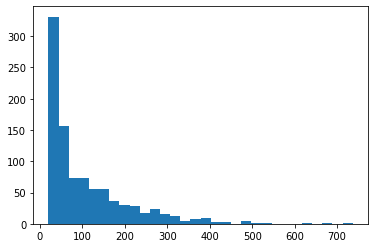

(943,) 279


In [0]:
import matplotlib.pyplot as plt

rating_user= np.zeros(processedRating_Df.shape)
rating_user[ii_train_matrix.nonzero()] = 1
num_rated_vector = np.sum(rating_user, axis =1)
plt.hist(num_rated_vector,bins=30)
plt.show()
print(num_rated_vector.shape,len(np.unique(num_rated_vector)))

In [0]:
def uu_cos_rec(train_matrix):
  temp_matrix = np.zeros(train_matrix.shape)
  temp_matrix[train_matrix.nonzero()] = 1
  uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
  normalizer = np.matmul(uu_similarity, temp_matrix)
  normalizer[normalizer==0] =1e-5
  predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
  useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
  columns = np.sum(predictionMatrix, axis=0)
  predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
  return predictionMatrix
def ii_cos_rec(train_matrix):
  train_matrix = train_matrix.T
  temp_matrix = np.zeros(train_matrix.shape)
  temp_matrix[train_matrix.nonzero()] = 1
  ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
  normalizer = np.matmul(ii_similarity, temp_matrix)
  normalizer[normalizer==0] = 1e-5
  predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

  itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
  columns = np.sum(predictionMatrix, axis=0)
  predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
  return predictionMatrix.T
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [0]:
datasetsFileNames = [('u1.base', 'u1.test'),\
                     ('u2.base', 'u2.test'),\
                     ('u3.base', 'u3.test'),\
                     ('u4.base', 'u4.test'),\
                     ('u5.base', 'u5.test')]
for item in datasetsFileNames:

  rating_df1 = getData(MOVIELENS_DIR, item[0])

  train_above=np.argwhere(num_rated_vector>100)
  train_below=np.argwhere(num_rated_vector<=100)

  training_above=rating_df1.loc[(rating_df1['userID']-1).isin(list(train_above))]
  training_above=dataPreprocessor(training_above,num_users,num_items)

  training_below=rating_df1.loc[(rating_df1['userID']-1).isin(list(train_below))]
  training_below=dataPreprocessor(training_below,num_users,num_items)

  testing_df1 = getData(MOVIELENS_DIR, item[1])
  testing_array1=dataPreprocessor(testing_df1,num_users,num_items)
  
  test_above=np.argwhere(num_rated_vector>100)
  test_below=np.argwhere(num_rated_vector<=100)

  testing_above=testing_df1.loc[(testing_df1['userID']-1).isin(list(test_above))]
  testing_above=dataPreprocessor(testing_above,num_users,num_items)

  testing_below=testing_df1.loc[(testing_df1['userID']-1).isin(list(test_below))]
  testing_below=dataPreprocessor(testing_below,num_users,num_items)

  uu_pred_above=uu_cos_rec(training_above)
  uu_pred_below=uu_cos_rec(training_below)
  ii_pred_above=ii_cos_rec(training_above)
  ii_pred_below=ii_cos_rec(training_below)
  print(item[1],'uu above',rmse(uu_pred_above,testing_above))
  print(item[1],'uu below',rmse(uu_pred_below,testing_below))
  print(item[1],'ii above',rmse(ii_pred_above,testing_above))
  print(item[1],'ii below',rmse(ii_pred_below,testing_below))
  print('EOL')

u1.test uu above 1.0241340610666714
u1.test uu below 1.0582562407076777
u1.test ii above 1.0443345682227039
u1.test ii below 1.110445423998786
EOL
u2.test uu above 1.0145575957195565
u2.test uu below 1.0801218601327083
u2.test ii above 1.0255539826357705
u2.test ii below 1.0769942007681863
EOL
u3.test uu above 1.0073962908888145
u3.test uu below 1.064924119715439
u3.test ii above 1.004512111419743
u3.test ii below 1.0890501701588764
EOL
u4.test uu above 1.0020697927093345
u4.test uu below 1.0711701531942723
u4.test ii above 1.0104093234429325
u4.test ii below 1.0892440558652547
EOL
u5.test uu above 1.0144224870401994
u5.test uu below 1.059024770448909
u5.test ii above 1.0245155078715824
u5.test ii below 1.067601559137488
EOL


From my observation, the users who has more ratings get higher rmse score. I think that maybe caused by the users who rate more than others has less sparsity in the matrix and eaiser to find similar users or items.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except Exception as e: 
        print(e)
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()


## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

(1682, 943)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)